![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [79]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Exploratory Data Analysis & Cleaning

In [80]:
# read csv
rental_df = pd.read_csv('rental_info.csv')
print(rental_df.info())
rental_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [81]:
# change dtypes
rental_df['rental_date'] = pd.to_datetime(rental_df['rental_date'], infer_datetime_format = True, errors = 'coerce')
rental_df['return_date'] = pd.to_datetime(rental_df['return_date'], infer_datetime_format = True, errors = 'coerce')
rental_df['length'] = rental_df['length'].astype('int')
rental_df['length_2'] = rental_df['length_2'].astype('int')
rental_df['release_year'] = rental_df['release_year'].astype('int')

In [82]:
# new columns
rental_df['rental_length_days'] = (rental_df['return_date'] - rental_df['rental_date']).dt.days
rental_df['deleted_scenes'] = np.where(rental_df['special_features'].str.contains('Deleted Scenes', regex = False), 1, 0)
rental_df['behind_the_scenes'] = np.where(rental_df['special_features'].str.contains('Behind the Scenes', regex = False), 1, 0)

rental_df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876,8.9401,4,0,1


## Machine Learning

In [83]:
# features and targets
X = rental_df.drop(['rental_date', 'return_date', 'special_features', 'rental_length_days'], axis = 1)
y = rental_df['rental_length_days']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

### Lasso Regression

In [85]:
# names of columns
names = rental_df.drop(['rental_date', 'return_date', 'special_features', 'rental_length_days'], axis = 1).columns

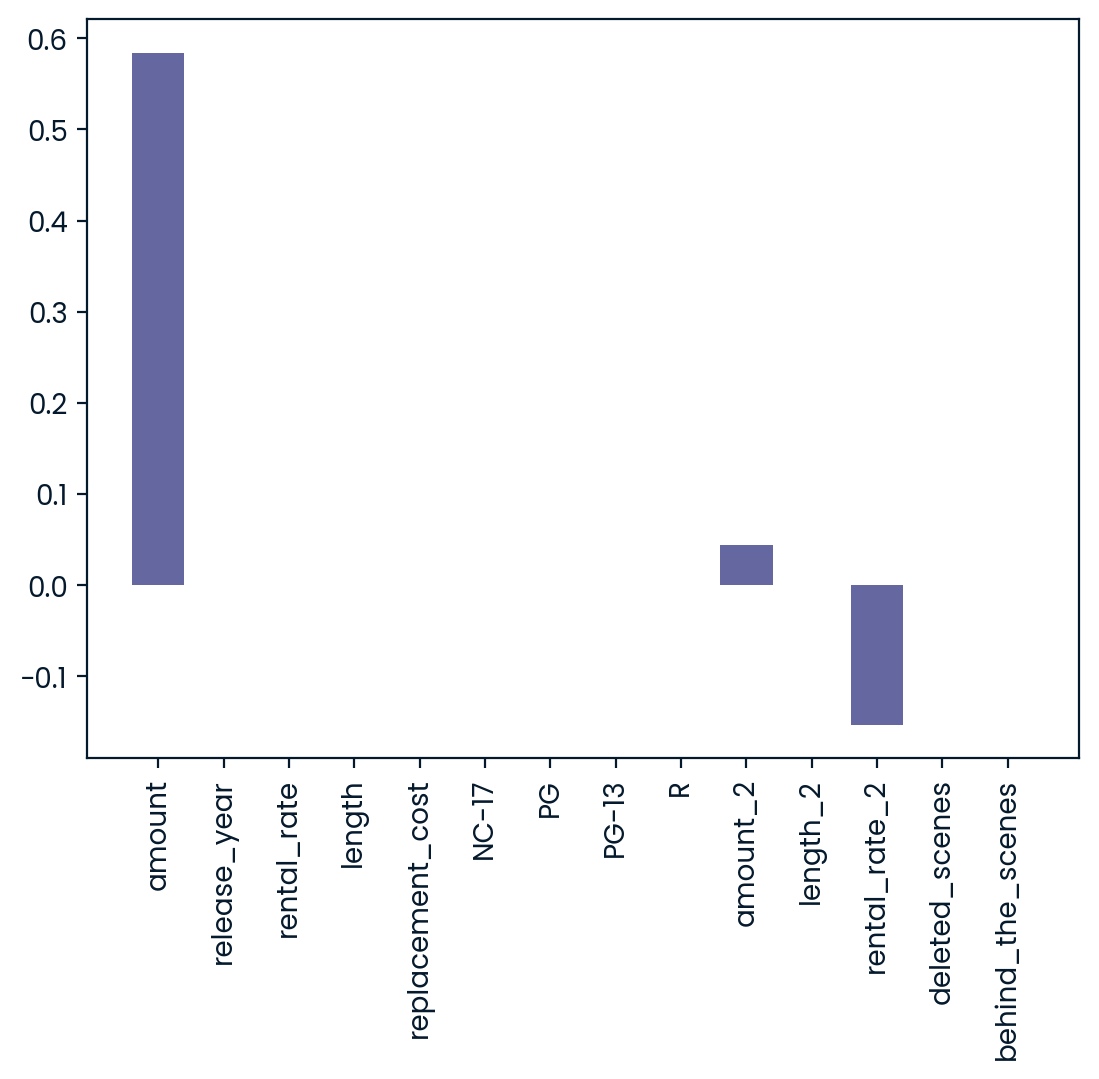

In [86]:
# check feature importance with Lasso
lasso = Lasso(alpha = 0.3, random_state = 9)
lasso_coef = lasso.fit(X_train, y_train).coef_

plt.bar(names, lasso_coef)
plt.xticks(rotation = 90)
plt.show()

In [87]:
# subset training and test based on feature selection
X_train_lasso = X_train.iloc[:, lasso_coef > 0]
X_test_lasso = X_test.iloc[:, lasso_coef > 0]

### Linear Regression Model

In [88]:
# linear regression model, fit and predict
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_mse = mean_squared_error(y_test, y_pred)
lr_mse

2.9417238646975883

### Linear Regression Model (using Feature Reduction via Lasso)

In [89]:
# linear regression model, fit and predict
lr_lasso = LinearRegression()
lr_lasso.fit(X_train_lasso, y_train)
y_pred = lr_lasso.predict(X_test_lasso)

lr_lasso_mse = mean_squared_error(y_test, y_pred)
lr_lasso_mse

4.812297241276244

### Random Forest Regressor

In [90]:
rf = RandomForestRegressor()

# param grid
rf_params = {'n_estimators': np.arange(1, 101, 1),
             'max_depth': np.arange(1, 11, 1)}

# random search for best params
random_search = RandomizedSearchCV(rf,
                                   param_distributions = rf_params,
                                   cv = 5,
                                   random_state = 9)

# fit data to random search
random_search.fit(X_train, y_train)

# best params
hyper_params = random_search.best_params_
hyper_params

{'n_estimators': 51, 'max_depth': 10}

In [91]:
# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators = hyper_params['n_estimators'], 
                           max_depth = hyper_params['max_depth'], 
                           random_state = 9)

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred)
rf_mse

2.225667528098759

### Decision Tree Regressor

In [92]:
dt = DecisionTreeRegressor()

# Define the parameter distribution to sample from
dt_params = {'max_depth': np.arange(1, 20, 1),
             'min_samples_split': np.arange(2, 20, 1),
             'min_samples_leaf': np.arange(1, 20, 1)}

# random search for best params
random_search = RandomizedSearchCV(dt,
                                   param_distributions = dt_params, 
                                   n_iter = 100,
                                   cv = 5,
                                   random_state = 9)

# best params
random_search.fit(X_train, y_train)
hyper_params = random_search.best_params_

In [93]:
# Run the random forest on the chosen hyper parameters
dt = DecisionTreeRegressor(max_depth = best_params_random['max_depth'],
                           min_samples_split = best_params_random['min_samples_split'],
                           min_samples_leaf = best_params_random['min_samples_leaf'],
                           random_state = 9)

dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
dt_mse = mean_squared_error(y_test, y_pred)

dt_mse

2.2504086646836683

### Best Model and MSE

In [94]:
best_model = rf
best_mse = rf_mse